# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — она сделана.

Построим модель с максимально большим значением accuracy. Доведем долю правильных ответов по крайней мере до 0.75. Проверим accuracy на тестовой выборке самостоятельно.

### Основные понятия и описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### План действий

- изучение данных;
- разбиение данных на выборки;
- исследование модулей;
- проверка модели на тестовой выборке;
- проверка модели на адекватность;
- общий вывод.

## Откройте и изучите файл

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# импортируем функцию для разбиения
from sklearn.model_selection import train_test_split

# импортируем функции машинного обучения
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier

In [3]:
# загружем данные
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('C:/Users/Student/Desktop/users_behavior.csv')

In [4]:
# pd.set_option('display.max_columns', None)
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
print(f"Всего строк: {len(df)}\n")
df.info()

Всего строк: 3214

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


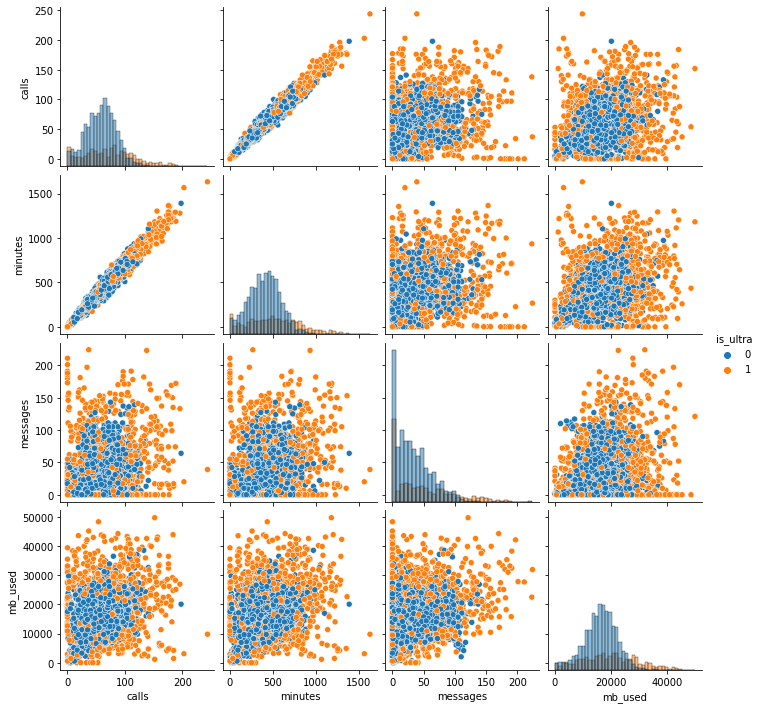

In [6]:
sns.pairplot(df, hue="is_ultra", diag_kind="hist")
plt.show()

In [7]:
print(f"Список характерных значений у пользователей с подпиской `Смарт`")
df.loc[df['is_ultra'] == 0].describe()

Список характерных значений у пользователей с подпиской `Смарт`


,calls,minutes,messages,mb_used,is_ultra
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.0
mean,58.463437,405.942952,33.384029,16208.466949,0.0
std,25.939858,184.512604,28.227876,5870.498853,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.230000,10.000000,12643.050000,0.0
50%,60.000000,410.560000,28.000000,16506.930000,0.0
75%,76.000000,529.510000,51.000000,20043.060000,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


In [8]:
print(f"Список характерных значений у пользователей с подпиской `Ультра`")
df.loc[df['is_ultra'] == 1].describe()

Список характерных значений у пользователей с подпиской `Ультра`


,calls,minutes,messages,mb_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


###### Вывод по итогу изучения общей информации

- столбец `is_ultra` является целевым признаком;
- остальные столбцы используем, как признаки;
- пользователи с подпиской `Ультра` активнее используют все услуги;
- довольно большое количество клиентов с любым типом подписки практически не пользуются сообщениями.

Целевой признак категориальный, решается задача классификации. Поскольку категорий всего две («Ультра» — 1, «Смарт» — 0) — речь идёт о бинарной (двоичной) классификации.

- поскольку данные обработаны, предобработка не требуется.

## Разбейте данные на выборки

Поскольку спрятанной тестовой выборки нет, данные нужно разбить на три части: обучающую, валидационную и тестовую.

- исходные данные разобьем в соотношении 3 (60% обучающую): 1 (20% валидационную): 1 (20% тестовую)

In [9]:
features = df.drop(['is_ultra'], axis=1) # талблица с признаками
target = df['is_ultra'] # столбец с целевым признаком

тут старое разбиение (закомментировано)
<!-- # отделим 20% для тестовой выборки
x, features_test, y, target_test = train_test_split(
    features, target, test_size=0.2, train_size=0.8, random_state=12345)

# оставшиеся данные разделим в соответствии с ожидаемыми размерами выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    x, y, test_size = 0.25, train_size =0.75, random_state=12345) -->

In [10]:
# отделим 60% для обучающей выборки
features_tv, features_train, target_tv, target_train = train_test_split(
    features, target, test_size=0.6, train_size=0.4, random_state=12345)

# оставшиеся данные разделим в соответствии с ожидаемыми размерами выборки
features_test, features_valid, target_test, target_valid = train_test_split(
    features_tv, target_tv, test_size = 0.5, train_size =0.5, random_state=12345)

In [11]:
print(f"Размер тестовой выборки: {len(features_test)}")
print(f"Размер валидационной выборки: {len(features_valid)}")
print(f"Размер обучающей выборки: {len(features_train)}")

Размер тестовой выборки: 642
Размер валидационной выборки: 643
Размер обучающей выборки: 1929


### Вывод по итогу разбиения данных на выборки

Ввиду отсутствия спрятанной тестовой выборки, данные нужно разбить на три части: обучающую, валидационную и тестовую.

- пропорции разбиения: `3:1:1` `(60% обучающая):(20% валидационная):(20% тестовая)`
- проверка размера подтвеждает правильность разбиения данных.

## Исследуйте модели

Поочередно исследуем разные модели для определения лучшей.

### Дерево решений

In [12]:
# подберем глубину и получим предсказания на валидационных данных

best_model = None
best_result = 0
best_depth = 0

for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # модель с некоторой глубиной дерева
    model.fit(features_train, target_train) # обучим модель
    
    predictions = model.predict(features_valid) # получим предсказания модели
    result = accuracy_score(target_valid, predictions) # посчитаем качество модели
    
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        
print(f"Accuracy лучшей модели на валидационной выборке: {best_result}. При глубине: {best_depth}")

Accuracy лучшей модели на валидационной выборке: 0.7900466562986003. При глубине: 5


###### Вывод по дереву решений

- отптимальной глубиной обучения оказалось `max_depth=5`;
- проблема переобучения не наблюдается.

При max_depth=3:
- Accuracy на валидационной выборке: 0.7900466562986003.

<!-- - Accuracy на обучающей выборке: 0.8117219917012448;
- Accuracy на тестовой выборке: 0.7869362363919129. -->

### Случайный лес

In [13]:
best_model = None
best_result = 0
best_est = 0

for est in range(1, 31):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) # модель с некоторым количеством деревьев
    model.fit(features_train, target_train) # обучим модель на тренировочной выборке
    result = model.score(features_valid, target_valid) # посчитаем качество модели на валидационной выборке
    
    if result > best_result:
        best_model = model # сохраним наилучшую модель
        best_result = result #  сохраним наилучшее значение метрики accuracy на валидационных данных
        best_est = est

print(f"Accuracy лучшей модели на валидационной выборке: {best_result}. При количестве деревьев: {best_est}")

Accuracy лучшей модели на валидационной выборке: 0.7993779160186625. При количестве деревьев: 11


###### Вывод по случайному лесу

- оптимальным количеством деревьев оказалось `n_estimators=11`;

При n_estimators=11:
- Accuracy лучшей модели на валидационной выборке: 0.7993779160186625.

<!-- - Accuracy на обучающей выборке: 0.9953319502074689;
- Accuracy на тестовой выборке: 0.7838258164852255. -->

### Логистическая регрессия

In [14]:
best_model = None
best_result = 0
best_max_iter = 0

for iter in range(100, 1001, 100):
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iter) # модель с некоторым количеством итераций
    model.fit(features_train, target_train) # обучим модель на тренировочной выборке
    result = model.score(features_valid, target_valid) # посчитаем качество модели на валидационной выборке
    
    if result > best_result:
        best_model = model # сохраним наилучшую модель
        best_result = result #  сохраним наилучшее значение метрики accuracy на валидационных данных
        best_max_iter = iter

print(f"Accuracy лучшей модели на валидационной выборке: {best_result}. При числе итераций: {best_max_iter}")

Accuracy лучшей модели на валидационной выборке: 0.7262830482115086. При числе итераций: 100


###### Вывод по логистической  регрессии

- оптимальным количеством итераций оказалось `max_iter=100`.

При max_iter=100:
- Accuracy лучшей модели на валидационной выборке: 0.7262830482115086.

<!-- - Accuracy на обучающей выборке: 0.7510373443983402;
- Accuracy на тестовой выборке: 0.7589424572317263. -->

### Вывод по итогу исследования моделей

Accuracy лучших моделей на валидационной выборке:
- Дерево решений: 0.7900466562986003. При глубине: 5
- Случайный лес: 0.7993779160186625. При количестве деревьев: 11
- Логистическая регрессия: 0.7262830482115086. При числе итераций: 100

Случайный лес является наиболее удачным методом для валидационной выборки. Однако, дерево решений тоже обладает приемлемым результатом.

## Проверьте модель на тестовой выборке

Проверим модель случайного леса на тестовой выборке

тут старая проверка (закомментировано)
<!-- # модель для заданного количества деревьев
model = RandomForestClassifier(random_state=12345, n_estimators=22)
model.fit(features_train, target_train)


# код расчёта на обучающей выборке
train_predictions = model.predict(features_train)
train_accuracy = accuracy_score(target_train, train_predictions)

# код расчёта на тестовой выборке
test_predictions = model.predict(features_test)
test_accuracy = accuracy_score(target_test, test_predictions)

print("Accuracy на обучающей выборке:", train_accuracy)
print("Accuracy на тестовой выборке:", test_accuracy) -->

In [15]:
# модель для заданного количества деревьев
model = RandomForestClassifier(random_state=12345, n_estimators=11)
model.fit(features_train, target_train)


# код расчёта на обучающей выборке
train_predictions = model.predict(features_train)
train_accuracy = accuracy_score(target_train, train_predictions)

# код расчёта на тестовой выборке
test_predictions = model.predict(features_test)
test_accuracy = accuracy_score(target_test, test_predictions)

# код расчёта на тестовой+валидациционной выборке
tv_predictions = model.predict(features_tv)
tv_accuracy = accuracy_score(target_tv, tv_predictions)

print("Accuracy на обучающей выборке:", train_accuracy)
print("Accuracy на тестовой выборке:", test_accuracy)
print("Accuracy на тестовой+валидациционной выборке:", tv_accuracy)

Accuracy на обучающей выборке: 0.991187143597719
Accuracy на тестовой выборке: 0.7866043613707165
Accuracy на тестовой+валидациционной выборке: 0.7929961089494163


### Вывод по проверке модели на тестовой выборке

- значения на обучениющей выборке довольно близкие к единице;
- значения на тестовой выборке практически идентичны валидационной выборке.

При количестве деревьев n_estimators=11:
- Accuracy на обучающей выборке: 0.991187143597719;
- Accuracy на тестовой выборке: 0.7866043613707165;
- Accuracy на тестовой+валидациционной выборке: 0.7929961089494163;
- Accuracy на валидационной выборке: 0.7993779160186625.

## (бонус) Проверьте модели на адекватность

Используя DummyClassifier оценим работу выбранной нами модели относительно разных сгенерированных/случайных.

In [16]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(features_train, target_train)


uniform_predictions = dummy_clf.predict(features_tv)
uniform_accuracy = accuracy_score(target_tv, uniform_predictions)

print("Accuracy на случайной выборке:", uniform_accuracy)

Accuracy на случайной выборке: 0.5120622568093385


In [17]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(features_train, target_train)


stratified_predictions = dummy_clf.predict(features_tv)
stratified_accuracy = accuracy_score(target_tv, stratified_predictions)

print("Accuracy на стратифицированной выборке:", stratified_accuracy)

Accuracy на стратифицированной выборке: 0.5673151750972762


### Вывод по итогу проверки модели на адекватность

Рассмотрев данные на случайной и стратифицированной моделях можем сказать, что наша выбранная модель Случайного леса имеет отличные показатели и адекватно справляется с поставленной задачей.

- Accuracy на случайной выборке: 0.5089494163424124;
- Accuracy на стратифицированной выборке: 0.5634241245136187.

## Итоговый вывод

###### Изучение данных

- пользователи с подпиской `Ультра` активнее используют все услуги;
- Довольно большое количество клиентов с любым типом подписки практически не пользуются сообщениями;
- столбец `is_ultra` является целевым признаком;
- остальные столбцы используем, как признаки.


- поскольку данные обработаны, предобработка не требуется.

###### Разбиение данных на выборки

Ввиду отсутствия спрятанной тестовой выборки, данные нужно разбить на три части: обучающую, валидационную и тестовую.

- пропорции разбиения: `3:1:1` `(60% обучающая):(20% валидационная):(20% тестовая)`
- проверка размера подтвеждает правильность разбиения данных.

###### Исследование моделей

Accuracy лучших моделей на валидационной выборке:

- Дерево решений: 0.7900466562986003. При глубине: 5
- Случайный лес: 0.7993779160186625. При количестве деревьев: 11
- Логистическая регрессия: 0.7262830482115086. При числе итераций: 100

Случайный лес является наиболее удачным методом для валидационной выборки. Однако, дерево решений тоже обладает приемлемым результатом.

###### Проверка модели на тестовой выборке

- значения на обучениющей выборке довольно близкие к единице;
- значения на тестовой выборке практически идентичны валидационной выборке.

При количестве деревьев n_estimators=11:
- Accuracy на обучающей выборке: 0.991187143597719;
- Accuracy на тестовой выборке: 0.7866043613707165;
- Accuracy на тестовой+валидациционной выборке: 0.7929961089494163;
- Accuracy на валидационной выборке: 0.7993779160186625.

> Данный значения (0.78) удовлетворяют требуемуму (0.75).

###### Проверка модели на адекватность

Рассмотрев данные на случайной и стратифицированной моделях можем сказать, что наша выбранная модель Случайного леса имеет отличные показатели и адекватно справляется с поставленной задачей.

- Accuracy на случайной выборке: 0.5089494163424124;
- Accuracy на стратифицированной выборке: 0.5634241245136187.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
